#### Import

In [31]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_rows", None)  # 모든 행 출력
pd.set_option("display.max_columns", None)  # 모든 열 출력
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios, plot_summary)
from utils import optimize_hol, optimize_without, optimize_without_loop, transform_step, compare_allstep, compare_onestep, compare_onestep_detailed, optimize_individually, optimize_individually_forall

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 5개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 524.csv, 89.csv
📊 데이터 Shape: I=5, T=24, S=20
✅ 시뮬레이션 초기화 완료: S=20, Randomness='high', M1=757.00, M2=2111.00


#### Individual Participation

In [32]:
x_ind, yp_ind, ym_ind, z_ind, zc_ind, zd_ind, obj_ind = optimize_individually_forall(R, K, K0, P_DA, P_RT, P_PN, I, T, S, M1)

Optimizing individually for each target_i:   0%|          | 0/5 [00:00<?, ?it/s]

Set parameter MIPGap to value 1e-07


Optimizing individually for each target_i:  20%|██        | 1/5 [00:00<00:00,  8.02it/s]

Optimal solution found for target_i=0! Objective value: 212864.3137148907
Set parameter MIPGap to value 1e-07


Optimizing individually for each target_i:  40%|████      | 2/5 [00:00<00:00,  8.83it/s]

Optimal solution found for target_i=1! Objective value: 341599.1289183394
Set parameter MIPGap to value 1e-07


Optimizing individually for each target_i:  60%|██████    | 3/5 [00:00<00:00,  8.43it/s]

Optimal solution found for target_i=2! Objective value: 385838.8922685327
Set parameter MIPGap to value 1e-07
Optimal solution found for target_i=3! Objective value: 473757.86246924783
Set parameter MIPGap to value 1e-07


Optimizing individually for each target_i: 100%|██████████| 5/5 [00:00<00:00,  9.14it/s]

Optimal solution found for target_i=4! Objective value: 164384.51523558467


#### Holistic Optimization

In [33]:
x_hol, a_hol, yp_hol, ym_hol, z_hol, zc_hol, zd_hol, ep_hol, bp_hol, em_hol, bm_hol, d_hol, dp_hol, dm_hol, obj_hol = optimize_hol(R, K, K0, P_DA, P_RT, P_PN, I, T, S, M1, M2)

Set parameter MIPGap to value 1e-07
Optimal solution found! Objective value: 1715933.4721934162


#### Holistic Optimization without target_i

In [34]:
x_without, ep_without, em_without, yp_without, ym_without, d_without, dp_without, dm_without, i_map_without = optimize_without_loop(R, K, K0, P_DA, P_RT, P_PN, I, T, S)

Solving settlement model for each target DER:   0%|          | 0/5 [00:00<?, ?it/s]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  20%|██        | 1/5 [00:06<00:25,  6.47s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  40%|████      | 2/5 [00:11<00:17,  5.67s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  60%|██████    | 3/5 [00:14<00:08,  4.41s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  80%|████████  | 4/5 [00:20<00:04,  4.89s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER: 100%|██████████| 5/5 [00:27<00:00,  5.59s/it]


#### Price Functions

In [158]:
def compute_price_functions(yp_without, ym_without, dp_without, dm_without, i_map_without, P_RT, P_PN, T, S, I):
    rdc_coefficients_all = np.full((I, T, S, 2), np.nan)
    rsc_coefficients_all = np.full((I, T, S, 2), np.nan)
    rho_plus_func_all = np.full((I, T, S, 2), np.nan)   # RDC
    rho_minus_func_all = np.full((I, T, S, 2), np.nan)  # RSC
    
    total_demand_without = np.zeros((I, T, S))
    total_supply_without = np.zeros((I, T, S))

    for target_i in range(I):
        yp_vals = yp_without[target_i]
        ym_vals = ym_without[target_i]
        dp_vals = dp_without[target_i]
        dm_vals = dm_without[target_i]
        i_map = i_map_without[target_i]

        for t in range(T):
            for s in range(S):
                total_supply = sum(yp_vals[i_map[i], t, s] for i in i_map)
                total_demand = sum(ym_vals[i_map[i], t, s] for i in i_map)
                
                total_supply_without[target_i, t, s] = total_supply
                total_demand_without[target_i, t, s] = total_demand

                given_profit = received_profit = realized_supply = realized_demand = 0

                for i in i_map:
                    given_profit += dp_vals[i_map[i], t, s] * P_PN[t]
                    received_profit += dm_vals[i_map[i], t, s] * P_RT[t, s]
                    realized_supply += dp_vals[i_map[i], t, s]
                    realized_demand += dm_vals[i_map[i], t, s]

                BIG_M_POS = 1e10
                BIG_M_NEG = -1e10

                if realized_demand <= 1e-4 or realized_supply <= 1e-4:
                    rho_plus_func_all[target_i, t, s, :] = [BIG_M_NEG, 0.0]
                    rho_minus_func_all[target_i, t, s, :] = [BIG_M_POS, 0.0]
                    continue

                a_d = P_PN[t]
                b_d = 2 * (a_d * realized_demand - received_profit) / (realized_demand ** 2)
                a_s = P_RT[t, s]
                b_s = 2 * (given_profit - a_s * realized_supply) / (realized_supply ** 2)

                denom = b_d + b_s
                if abs(denom) < 1e-6: continue

                # === RDC: q0 → 공급 증가 ===
                q0_list_rdc = np.linspace(-5, 1.1 * total_supply, 10)
                prices_rdc = []
                for q0 in q0_list_rdc:
                    q_cleared = (a_d - a_s + b_s * q0) / denom
                    p_cleared = a_d - b_d * q_cleared
                    prices_rdc.append(p_cleared)
                q_rdc = np.array(q0_list_rdc).reshape(-1, 1)
                p_rdc = np.array(prices_rdc)

                # === RSC: q0 → 수요 증가 ===
                q0_list_rsc = np.linspace(-5, 1.1 * total_demand, 10)
                prices_rsc = []
                for q0 in q0_list_rsc:
                    q_cleared = (a_d + b_d * q0 - a_s) / denom
                    p_cleared = a_s + b_s * q_cleared
                    prices_rsc.append(p_cleared)
                q_rsc = np.array(q0_list_rsc).reshape(-1, 1)
                p_rsc = np.array(prices_rsc)

                # 선형 회귀 근사 (1차)
                X_poly_rdc = PolynomialFeatures(degree=1).fit_transform(q_rdc)
                X_poly_rsc = PolynomialFeatures(degree=1).fit_transform(q_rsc)

                model_rdc = LinearRegression().fit(X_poly_rdc, p_rdc)
                model_rsc = LinearRegression().fit(X_poly_rsc, p_rsc)

                a_rdc, b_rdc = model_rdc.intercept_, model_rdc.coef_[1]
                a_rsc, b_rsc = model_rsc.intercept_, model_rsc.coef_[1]

                rho_plus_func_all[target_i, t, s, :] = [a_rdc, b_rdc]
                rho_minus_func_all[target_i, t, s, :] = [a_rsc, b_rsc]
                rdc_coefficients_all[target_i, t, s, :] = [a_rdc, b_rdc]
                rsc_coefficients_all[target_i, t, s, :] = [a_rsc, b_rsc]

    return rdc_coefficients_all, rsc_coefficients_all, rho_plus_func_all, rho_minus_func_all, total_demand_without, total_supply_without

In [159]:
rdc, rsc, rho_plus, rho_minus, total_demand_without, total_supply_without = compute_price_functions(
    yp_without, ym_without, dp_without, dm_without, i_map_without, P_RT, P_PN, T, S, I
)

In [160]:
target_i, t, s = 0, 20, 1

ap, bp = rho_plus[target_i, t, s, :]
am, bm = rho_minus[target_i, t, s, :]

print(f"ρ⁺(d) = {ap:.2f} + {bp:.2f}·d")
print(f"ρ⁻(d) = {am:.2f} + {bm:.2f}·d")

ρ⁺(d) = -10000000000.00 + 0.00·d
ρ⁻(d) = 10000000000.00 + 0.00·d


#### Transform Stepwise

In [161]:
RP, RM, BP, BM = transform_step(rho_plus, rho_minus, total_demand_without, total_supply_without, step_width_multiplier=1)

In [162]:
target_i, t, s = 0, 20, 2

print(yp_without[target_i][:, t, s])
print(i_map_without[target_i])
print(BP[target_i, t, s])
print(RP[target_i, t, s])

print(ym_without[target_i][:, t, s])
print(i_map_without[target_i])
print(BM[target_i, t, s])
print(RM[target_i, t, s])

[ 0.  0.  0. 10.]
{1: 0, 2: 1, 3: 2, 4: 3}
10
[[  0.         134.57081575]
 [  0.5        130.53549732]
 [  1.5        122.46486047]
 [  2.5        114.39422362]
 [  3.5        106.32358677]
 [  4.5         98.25294992]
 [  5.5         90.18231307]
 [  6.5         82.11167622]
 [  7.5         74.04103937]
 [  8.5         65.97040252]
 [  9.5         57.89976567]]
[0. 8. 2. 0.]
{1: 0, 2: 1, 3: 2, 4: 3}
10
[[  0.         134.57081575]
 [  0.5        138.60613417]
 [  1.5        146.67677102]
 [  2.5        154.74740787]
 [  3.5        162.81804472]
 [  4.5        170.88868157]
 [  5.5        178.95931843]
 [  6.5        187.02995528]
 [  7.5        195.10059213]
 [  8.5        203.17122898]
 [  9.5        211.24186583]]


#### Stepwise Model

In [163]:
x_part, yp_part, ym_part, z_part, zc_part, zd_part, dp_part, dm_part, up_part, um_part, wp_part, wm_part, obj_part = [], [], [], [], [], [], [], [], [], [], [], [], []

for target_i in tqdm(range(I), desc="Optimizing Stepwise for each target_i"):
    model = gp.Model("Stepwise_Internal_Optimization_{target_i}")
    model.setParam("OutputFlag", 0)
    model.setParam("MIPGap", 1e-7)

    x = model.addVars(T, vtype=GRB.CONTINUOUS, lb=0, name="x")
    yp = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
    ym = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
    z = model.addVars(T + 1, S, vtype=GRB.CONTINUOUS, lb=0, name="z")
    zc = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="z_charge")
    zd = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="z_discharge")
    dp = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="d_plus")
    dm = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="d_minus")

    p1  = model.addVars(T, S, vtype=GRB.BINARY, name="p1")
    p2  = model.addVars(T, S, vtype=GRB.BINARY, name="p2")
    p3  = model.addVars(T, S, vtype=GRB.BINARY, name="p3")
    p4  = model.addVars(T, S, vtype=GRB.BINARY, name="p4")
    # p5  = model.addVars(T, S, vtype=GRB.BINARY, name="p5")
    # p6  = model.addVars(T, S, vtype=GRB.BINARY, name="p6")
    
    wp, up = {}, {}
    wm, um = {}, {}
    for t, s in product(range(T), range(S)):
        Bp = BP[target_i, t, s]
        Bm = BM[target_i, t, s]
        for b in range(Bp):
            wp[t, s, b] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"w_plus_{t}_{s}_{b}")
            up[t, s, b] = model.addVar(vtype=GRB.BINARY, name=f"u_plus_{t}_{s}_{b}")
        for b in range(Bm):
            wm[t, s, b] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"w_minus_{t}_{s}_{b}")
            um[t, s, b] = model.addVar(vtype=GRB.BINARY, name=f"u_minus_{t}_{s}_{b}")

    model.update()

    obj = gp.quicksum(P_DA[t] * x[t] for t in range(T)) \
        + gp.quicksum((1/S) * (P_RT[t, s] * yp[t, s] - P_PN[t] * ym[t, s]) for t in range(T) for s in range(S)) \
        + gp.quicksum((1/S) * (
            gp.quicksum(
                RP[target_i, t, s][b][1] * (wp[t, s, b] + up[t, s, b] * RP[target_i, t, s][b][0])
                for b in range(BP[target_i, t, s])
            ) -
            gp.quicksum(
                RM[target_i, t, s][b][1] * (wm[t, s, b] + um[t, s, b] * RM[target_i, t, s][b][0])
                for b in range(BM[target_i, t, s])
            )
        ) for t in range(T) for s in range(S))

    model.setObjective(obj, GRB.MAXIMIZE)

    for t, s in product(range(T), range(S)):
        model.addConstr(R[target_i, t, s] - x[t] == yp[t, s] - ym[t, s] + zc[t, s] - zd[t, s] + dp[t, s] - dm[t, s])
        model.addConstr(yp[t, s] + dp[t, s] + zc[t, s] <= R[target_i, t, s] + zd[t, s])
        model.addConstr(z[t + 1, s] == z[t, s] + zc[t, s] - zd[t, s])
        model.addConstr(zd[t, s] <= z[t, s])
        model.addConstr(zc[t, s] <= K[target_i] - z[t, s])
        model.addConstr(z[t, s] <= K[target_i])
        model.addConstr(z[t, s] >= 0)
        model.addConstr(yp[t, s] <= M1 * p1[t, s])
        model.addConstr(ym[t, s] <= M1 * (1 - p1[t, s]))
        model.addConstr(ym[t, s] <= M1 * p2[t, s])
        model.addConstr(zc[t, s] <= M1 * (1 - p2[t, s]))
        model.addConstr(zc[t, s] <= M1 * p3[t, s])
        model.addConstr(zd[t, s] <= M1 * (1 - p3[t, s]))
        model.addConstr(dp[t, s] <= M1 * p4[t, s])
        model.addConstr(dm[t, s] <= M1 * (1 - p4[t, s]))
        # model.addConstr(zc[t, s] <= M1 * p5[t, s])
        # model.addConstr(dm[t, s] <= M1 * (1 - p5[t, s]))
        # model.addConstr(zd[t, s] <= M1 * p6[t, s])
        # model.addConstr(dp[t, s] <= M1 * (1 - p6[t, s]))

    for s in range(S):
        model.addConstr(z[0, s] == K0[target_i])

    for t, s in product(range(T), range(S)):
        model.addConstr(dp[t, s] == gp.quicksum(wp[t, s, bp] + up[t, s, bp] * RP[target_i, t, s][bp][0]
                                                for bp in range(BP[target_i, t, s])))
        model.addConstr(dm[t, s] == gp.quicksum(wm[t, s, bm] + um[t, s, bm] * RM[target_i, t, s][bm][0]
                                                for bm in range(BM[target_i, t, s])))

        model.addConstr(gp.quicksum(up[t, s, bp] for bp in range(BP[target_i, t, s])) <= 1)
        model.addConstr(gp.quicksum(um[t, s, bm] for bm in range(BM[target_i, t, s])) <= 1)
            
        for bp in range(BP[target_i, t, s]):
            if bp < BP[target_i, t, s] - 1:
                WIDTH = RP[target_i, t, s][bp + 1][0] - RP[target_i, t, s][bp][0]
            else:
                WIDTH = max(1e-6, total_supply_without[target_i, t, s] - RP[target_i, t, s][bp][0])
            model.addConstr(wp[t, s, bp] <= up[t, s, bp] * WIDTH)

        for bm in range(BM[target_i, t, s]):
            if bm < BM[target_i, t, s] - 1:
                WIDTH = RM[target_i, t, s][bm + 1][0] - RM[target_i, t, s][bm][0]
            else:
                WIDTH = max(1e-6, total_demand_without[target_i, t, s] - RM[target_i, t, s][bm][0])
            model.addConstr(wm[t, s, bm] <= um[t, s, bm] * WIDTH)

    model.optimize()

    x_part.append(np.array([x[t].X for t in range(T)]))
    yp_part.append(np.array([[yp[t, s].X for s in range(S)] for t in range(T)]))
    ym_part.append(np.array([[ym[t, s].X for s in range(S)] for t in range(T)]))
    z_part.append(np.array([[z[t, s].X for s in range(S)] for t in range(T + 1)]))
    zc_part.append(np.array([[zc[t, s].X for s in range(S)] for t in range(T)]))
    zd_part.append(np.array([[zd[t, s].X for s in range(S)] for t in range(T)]))
    dp_part.append(np.array([[dp[t, s].X for s in range(S)] for t in range(T)]))
    dm_part.append(np.array([[dm[t, s].X for s in range(S)] for t in range(T)]))
    obj_part.append(model.objVal)
    
    MAX_BP = np.max(BP[target_i])
    MAX_BM = np.max(BM[target_i])

    up_array = np.full((T, S, MAX_BP), np.nan)
    um_array = np.full((T, S, MAX_BM), np.nan)
    wp_array = np.full((T, S, MAX_BP), np.nan)
    wm_array = np.full((T, S, MAX_BM), np.nan)

    for t, s in product(range(T), range(S)):
        for bp in range(BP[target_i, t, s]):
            up_array[t, s, bp] = up[t, s, bp].X
            wp_array[t, s, bp] = wp[t, s, bp].X
        for bm in range(BM[target_i, t, s]):
            um_array[t, s, bm] = um[t, s, bm].X
            wm_array[t, s, bm] = wm[t, s, bm].X

    up_part.append(up_array)
    um_part.append(um_array)
    wp_part.append(wp_array)
    wm_part.append(wm_array)

Optimizing Stepwise for each target_i: 100%|██████████| 5/5 [00:21<00:00,  4.20s/it]


In [164]:
RPC = np.full((I, T, S), np.nan)
RMC = np.full((I, T, S), np.nan)

for target_i in range(I):
    for s, t in product(range(S), range(T)):
        for bp in range(BP[target_i, t, s]):
            if round(up_part[target_i][t, s, bp]) == 1:
                RPC[target_i, t, s] = RP[target_i, t, s][bp][1]
                # print(f"[i={target_i}, t={t}, s={s}] bp={bp}, price={RP[target_i, t, s][bp][1]}, quantity={dp_part[target_i][t, s]} (D_min={RP[target_i, t, s][bp][0]} + w={wp_part[target_i][t, s, bp]})")
                break

        for bm in range(BM[target_i, t, s]):
            if round(um_part[target_i][t, s, bm]) == 1:
                RMC[target_i, t, s] = RM[target_i, t, s][bm][1]
                # print(f"[i={target_i}, t={t}, s={s}] bm={bm}, price={RM[target_i, t, s][bm][1]}, quantity={dm_part[target_i][t, s]} (D_min={RM[target_i, t, s][bm][0]} + w={wm_part[target_i][t, s, bm]})")
                break

#### Results

In [165]:
target_i = 2

header = (
    f"{'s':>2} {'t':>2} | "
    f"{'R':>8} {'x':>8} {'y+':>8} {'y-':>8} "
    f"{'d+':>8} {'d-':>8} {'zc':>8} {'zd':>8} {'z':>8}\n"
    + "-" * 90
)
print(header)

for s, t in product(range(1,2), range(T)):
    print(
        f"{s:>2} {t:>2} | "
        f"{R[target_i, t, s]:>8.2f} {x_part[target_i][t]:>8.2f} {yp_part[target_i][t, s]:>8.2f} {ym_part[target_i][t, s]:>8.2f} "
        f"{dp_part[target_i][t, s]:>8.2f} {dm_part[target_i][t, s]:>8.2f} {zc_part[target_i][t, s]:>8.2f} {zd_part[target_i][t, s]:>8.2f} {z_part[target_i][t, s]:>8.2f}"
    )

 s  t |        R        x       y+       y-       d+       d-       zc       zd        z
------------------------------------------------------------------------------------------
 1  0 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 1  1 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 1  2 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 1  3 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 1  4 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 1  5 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 1  6 |     4.00     0.00     0.00     0.00     0.00     0.00     4.00     0.00     0.00
 1  7 |     7.00     0.00     0.00     0.00     0.00     0.00     7.00     0.00     4.00
 1  8 |     3.00     0.00    14.00     0.00     0.00     0.00     0.00    11.00    11.00
 1  9 |    73.00   

In [166]:
df_rho_cleared = pd.DataFrame([
    {
        "i": target_i,
        "t": t,
        "s": s,
        "..": "||", 
        "RT": P_RT[t, s],
        "yp": yp_part[target_i][t, s],
        "rho_plus": RPC[target_i, t, s],
        "dp": dp_part[target_i][t, s],
        ".": "|", 
        "PN": P_PN[t],
        "ym": ym_part[target_i][t, s],
        "rho_minus": RMC[target_i, t, s],
        "dm": dm_part[target_i][t, s]
    }
    for s in range(0,1)
    for t in range(T)
])

pd.DataFrame(df_rho_cleared)

,i,t,s,..,RT,yp,rho_plus,dp,.,PN,ym,rho_minus,dm
0,2,0,0,||,52.112,0.000,-10000000000.000,0.000,|,137.214,0.000,10000000000.000,0.000
1,2,1,0,||,104.434,0.000,-10000000000.000,0.000,|,119.736,0.000,10000000000.000,0.000
2,2,2,0,||,55.635,0.000,-10000000000.000,0.000,|,110.610,0.000,10000000000.000,0.000
3,2,3,0,||,78.375,0.000,-10000000000.000,0.000,|,106.668,0.000,10000000000.000,0.000
4,2,4,0,||,71.220,0.000,-10000000000.000,0.000,|,106.362,0.000,10000000000.000,0.000
5,2,5,0,||,76.733,0.000,-10000000000.000,0.000,|,110.502,0.000,10000000000.000,0.000
6,2,6,0,||,72.227,0.000,-10000000000.000,0.000,|,120.276,0.000,10000000000.000,0.000
7,2,7,0,||,94.466,5.000,-10000000000.000,0.000,|,131.562,0.000,10000000000.000,0.000
8,2,8,0,||,77.202,0.000,-10000000000.000,0.000,|,157.014,0.000,10000000000.000,0.000
9,2,9,0,||,74.498,0.000,-10000000000.000,0.000,|,169.902,0.000,10000000000.000,0.000


In [167]:
target_i = 0
compare_onestep(a_hol, bp_hol, bm_hol, dp_hol, dm_hol, x_part, yp_part, ym_part, dp_part, dm_part, x_without, ep_without, em_without, dp_without, dm_without, T, target_i)
print()
compare_onestep_detailed(a_hol, bp_hol, bm_hol, dp_hol, dm_hol, x_part, yp_part, ym_part, dp_part, dm_part, x_without, ep_without, em_without, dp_without, dm_without, T, target_i)

=== [시나리오 평균] set 모델 vs (PWL + without) 결과 비교 (target_i=0) ===

 t |      a_opt      x_sum ||     bp_opt     yp_avg ||     bm_opt     ym_avg ||     dp_opt     dp_avg ||     dm_opt     dm_avg
-----------------------------------------------------------------------------------------------------------------------------
 0 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 1 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 2 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 3 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 4 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 5 |      0.000      0.000 ||      0.050      0.

In [168]:
compare_allstep(a_hol, bp_hol, bm_hol, dp_hol, dm_hol, x_part, yp_part, ym_part, dp_part, dm_part, T)

=== [시나리오 평균] set 모델 vs 전체 PWL 결과 비교 ===

 t |      a_opt  x_pwl_sum ||     bp_opt     yp_avg ||     bm_opt     ym_avg ||     dp_opt     dp_avg ||     dm_opt     dm_avg
-----------------------------------------------------------------------------------------------------------------------------
 0 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 1 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 2 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 3 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 4 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 5 |      0.000      0.000 ||      0.050      0.050 ||      0.000     

=== Individual Participation vs Stepwise Model 비교 (target_i=0) ===
 t |    x_ind   x_step ||   yp_ind  yp_step  dp_step ||   ym_ind  ym_step  dm_step
--------------------------------------------------------------------------------
 0 |    0.000    0.000 ||    0.000    0.000    0.000 ||    0.000    0.000    0.000
 1 |    0.000    0.000 ||    0.000    0.000    0.000 ||    0.000    0.000    0.000
 2 |    0.000    0.000 ||    0.000    0.000    0.000 ||    0.000    0.000    0.000
 3 |    0.000    0.000 ||    0.000    0.000    0.000 ||    0.000    0.000    0.000
 4 |    0.000    0.000 ||    0.000    0.000    0.000 ||    0.000    0.000    0.000
 5 |    0.000    0.000 ||    0.000    0.000    0.000 ||    0.000    0.000    0.000
 6 |    0.000    0.000 ||    0.000    0.000    0.000 ||    0.000    0.000    0.000
 7 |    0.000    0.000 ||    0.000    0.000    0.000 ||    0.000    0.000    0.000
 8 |    0.000    0.000 ||    4.550    2.100    0.000 ||    0.000    0.000    0.000
 9 |    0.000    0.000

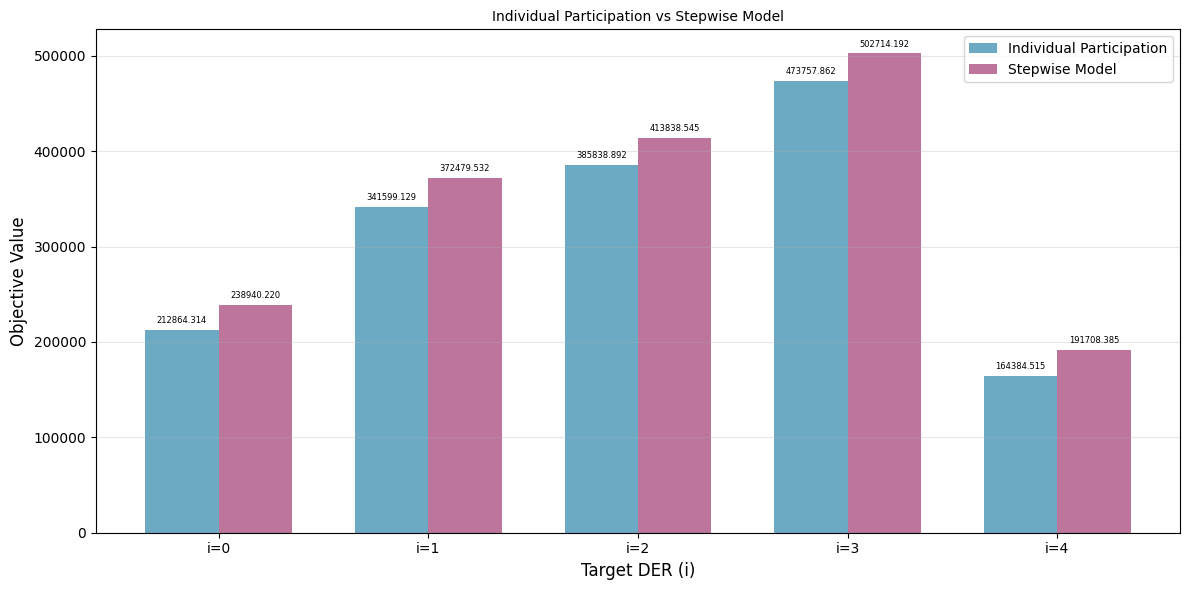

In [169]:
for target_i in range(I):
    print(f"=== Individual Participation vs Stepwise Model 비교 (target_i={target_i}) ===")
    print(f"{'t':>2} | {'x_ind':>8} {'x_step':>8} || {'yp_ind':>8} {'yp_step':>8} {'dp_step':>8} || {'ym_ind':>8} {'ym_step':>8} {'dm_step':>8}")
    print("-" * 80)

    for t in range(T):
        x_ind_avg = np.mean(x_ind[target_i][t])
        yp_ind_avg = np.mean(yp_ind[target_i][t, :])
        ym_ind_avg = np.mean(ym_ind[target_i][t, :])
        
        x_step = x_part[target_i][t]
        yp_step = np.mean(yp_part[target_i][t, :])
        ym_step = np.mean(ym_part[target_i][t, :])
        dp_step = np.mean(dp_part[target_i][t, :])
        dm_step = np.mean(dm_part[target_i][t, :])
        
        print(f"{t:>2} | {x_ind_avg:>8.3f} {x_step:>8.3f} || {yp_ind_avg:>8.3f} {yp_step:>8.3f} {dp_step:>8.3f} || {ym_ind_avg:>8.3f} {ym_step:>8.3f} {dm_step:>8.3f}")

    print(f"\n=== Objective Value 비교 ===")
    print(f"Individual Participation: {obj_ind[target_i]:.3f}")
    print(f"Stepwise Model: {obj_part[target_i]:.3f}")

fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(I)
width = 0.35

ind_values = [obj_ind[i] for i in range(I)]
step_values = [obj_part[i] for i in range(I)]

bars1 = ax.bar(x_pos - width/2, ind_values, width, label='Individual Participation', color='#2E86AB', alpha=0.7)
bars2 = ax.bar(x_pos + width/2, step_values, width, label='Stepwise Model', color='#A23B72', alpha=0.7)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(max(ind_values), max(step_values))*0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=6)

ax.set_xlabel('Target DER (i)', fontsize=12)
ax.set_ylabel('Objective Value', fontsize=12)
ax.set_title('Individual Participation vs Stepwise Model', fontsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels([f'i={i}' for i in range(I)])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()